ANN MODEL

In [30]:
import pandas as pd
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk#for text wrangling
import spacy#for text wrangling
import re
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [31]:
df = pd.read_csv("dataset.csv")
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
df.label.value_counts()

label
ham     14337
spam     6011
Name: count, dtype: int64

In [33]:
df.dropna(inplace = True)


In [34]:
df

,label,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...
...,...,...
20343,ham,/ban
20344,ham,/ban
20345,ham,/ban
20346,ham,Kaisi hii


In [35]:
sum(df.text.notna())
#there is no null category as well as no null message so we dont need to handle that.

20348

In [36]:
X = df['text']
Y = df['label']

In [37]:
STOPWORDS = stopwords.words("english")

In [38]:
import spacy
from tqdm import tqdm
import pandas as pd
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOPWORDS

# Load spaCy with minimal components, and enable multi-core processing
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser","entity_linker"])

# Custom preprocessing function that works on a list of texts
def text_preprocess(texts, batch_size=1000, n_process=4):
    cleaned = []

    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process)):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.lemma_ != "-PRON-"
            and token.lemma_.lower() not in SPACY_STOPWORDS
            and not token.is_space
            and not token.is_punct
        ]
        cleaned.append(" ".join(tokens))
    
    return cleaned


X_cleaned = pd.Series(text_preprocess(X.tolist()))


20348it [00:56, 360.99it/s] 


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, Y, test_size=0.3, random_state=42, stratify=Y
)

# Optional but safer
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from joblib import parallel_backend

# CountVectorizer is a bit faster and lets us control preprocessing
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    max_features=20000,
    lowercase=False
)

tfidf_transformer = TfidfTransformer()

pipeline = Pipeline([
    ('vect', count_vectorizer),
    ('tfidf', tfidf_transformer)
])

with parallel_backend('loky', n_jobs=3):  # Use all cores
    X_enc = pipeline.fit_transform(X_train)
    X_test_enc = pipeline.transform(X_test)

In [42]:
X_dense = X_enc.toarray()

In [43]:
from sklearn.utils import class_weight
import numpy as np

y_train_enc = np.array(y_train)  # Just to be safe

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train_enc
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Computed class weights:", class_weight_dict)

Computed class weights: {'ham': 0.7096661684105631, 'spam': 1.6923716730038023}


In [44]:
from sklearn.preprocessing import LabelEncoder

# Initialize and fit encoder
le = LabelEncoder()

# Transform text labels to integers
y_train = le.fit_transform(y_train)

# Optional: encode y_test too if needed later
y_test = le.transform(y_test)


In [45]:
from gensim.models import Word2Vec
import pandas as pd
tokenized_corpus = [text.split() for text in X_train]
# Tokenize the training data

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=150,      # You can increase this (e.g., 200, 300)
    window=6,             # Context window size
    min_count=2,          # Ignore rare words
    workers=5,            # Cores for training
    sg=1,                 # Use skip-gram; CBOW = 0
    epochs=30             # More is better for smaller datasets
)
w2v_model.save("word2vec.model")

In [46]:
from collections import defaultdict
import numpy as np
import math

def compute_idf(tokenized_corpus):
    """Compute IDF dictionary for a tokenized corpus."""
    N = len(tokenized_corpus)
    df = defaultdict(int)

    for doc in tokenized_corpus:
        unique_tokens = set(doc)
        for token in unique_tokens:
            df[token] += 1

    idf_dict = {}
    for word, freq in df.items():
        idf_dict[word] = math.log((N + 1) / (freq + 1)) + 1  # Smooth IDF

    return idf_dict

def get_tfidf_weighted_w2v(tokens_list, model, idf, k=150):
    vectors = []
    for tokens in tokens_list:
        vecs = []
        for word in tokens:
            if word in model.wv:
                weight = idf.get(word, 1.0)
                vecs.append(weight * model.wv[word])
        if vecs:
            vectors.append(np.mean(vecs, axis=0))
        else:
            vectors.append(np.zeros(k))
    return np.vstack(vectors)

X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]
idf_dict = compute_idf(X_train_tokens)
X_train_vecs = get_tfidf_weighted_w2v(X_train_tokens, w2v_model, idf_dict, k=150)
X_test_vecs = get_tfidf_weighted_w2v(X_test_tokens, w2v_model, idf_dict, k=150)

In [47]:
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable



# 1. Define the Focal Loss Function
@register_keras_serializable(package="Custom", name="focal_loss_fixed")
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal loss function.
    Args:
        y_true: Ground truth labels (tensor of shape (batch_size, num_classes)).
        y_pred: Predicted probabilities (tensor of shape (batch_size, num_classes)).
        gamma: Focusing parameter to reduce the relative loss for well-classified examples.
        alpha: Weighting factor to balance the importance of positive and negative examples.
    Returns:
        A scalar tensor representing the mean focal loss.
    """
    # Ensure y_true and y_pred are of the same data type
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    loss = alpha * tf.keras.backend.pow((1 - p_t), gamma) * bce
    return tf.keras.backend.mean(loss)

# 2. Wrapper for Parameterization with proper serialization
@register_keras_serializable(package="Custom", name="focal_loss")
def focal_loss(gamma=2.0, alpha=0.25):
    """
    A wrapper function to allow you to specify the gamma and alpha
    parameters when using the loss.
    """
    @register_keras_serializable(package="Custom", name="focal_loss_fn")
    def focal_loss_fn(y_true, y_pred):
        return focal_loss_fixed(y_true, y_pred, gamma=gamma, alpha=alpha)
    
    # These attributes help with serialization
    focal_loss_fn.__name__ = "focal_loss_fn"
    focal_loss_fn._uses_gamma = gamma  # Store parameters as attributes
    focal_loss_fn._uses_alpha = alpha
    
    return focal_loss_fn

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC


w2v_modelNN = Sequential([
    Input(shape=(X_train_vecs.shape[1],)),  # Should be 100 or whatever you used in Word2Vec
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128,activation="relu"),
    Dropout(0.3),
    Dense(32,activation="relu"),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
w2v_modelNN.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=focal_loss(gamma=1.7, alpha=0.25),  # Notice the parentheses here
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

w2v_modelNN.fit(
    X_train_vecs, 
    y_train, 
    epochs=25, 
    batch_size=128, 
    validation_split=0.2, 
    class_weight=class_weight_dict, 
    callbacks=[early_stopping, lr_reduction]
)


Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7070 - auc: 0.7694 - loss: 0.0619 - precision: 0.5088 - recall: 0.6870 - val_accuracy: 0.9214 - val_auc: 0.9627 - val_loss: 0.0217 - val_precision: 0.8384 - val_recall: 0.9100 - learning_rate: 5.0000e-04
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - auc: 0.9260 - loss: 0.0273 - precision: 0.7742 - recall: 0.8079 - val_accuracy: 0.9252 - val_auc: 0.9701 - val_loss: 0.0176 - val_precision: 0.8614 - val_recall: 0.8910 - learning_rate: 5.0000e-04
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8981 - auc: 0.9483 - loss: 0.0223 - precision: 0.8502 - recall: 0.7956 - val_accuracy: 0.9326 - val_auc: 0.9729 - val_loss: 0.0155 - val_precision: 0.8976 - val_recall: 0.8720 - learning_rate: 5.0000e-04
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9077 - auc: 0.9560 - loss: 0.0203 - precision: 0.8543 - recall: 0.8297 - val_accuracy: 0.9417 - val_auc: 0.9768 - val_loss: 0.0146 -

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
Confusion Matrix:
 [[4132  170]
 [ 131 1672]]

Classification Report:
               precision    recall  f1-score   support

         Ham       0.97      0.96      0.96      4302
        Spam       0.91      0.93      0.92      1803

    accuracy                           0.95      6105
   macro avg       0.94      0.94      0.94      6105
weighted avg       0.95      0.95      0.95      6105



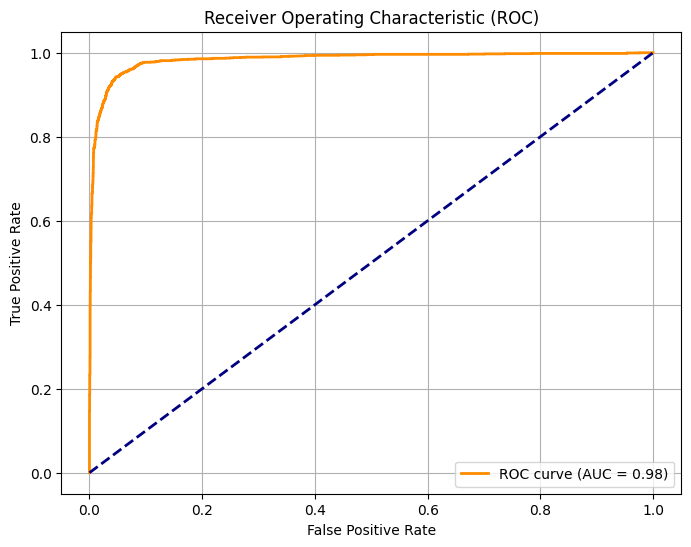

In [50]:
#w2v ann model test results

import numpy as np

# Get raw probability predictions
y_pred_prob = w2v_modelNN.predict(X_test_vecs)

# Convert probabilities to binary predictions using a threshold
threshold = 0.5  # You can tune this
y_pred = (y_pred_prob > threshold).astype(int).flatten()

from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
cr = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
print("\nClassification Report:\n", cr)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [51]:
def predict_w2v(text, k=150):
    # Ensure input is a single string
    if not isinstance(text, str):
        raise ValueError("Input should be a single string of text.")
    
    # Preprocess using your batch-friendly function
    cleaned_text = text_preprocess([text])[0]  # returns list; take first element
    tokens = cleaned_text.split()

    # Compute TF-IDF weighted average Word2Vec vector
    vecs = []
    for word in tokens:
        if word in w2v_model.wv:
            weight = idf_dict.get(word, 1.0)
            vecs.append(weight * w2v_model.wv[word])
    
    if vecs:
        input_vector = np.mean(vecs, axis=0).reshape(1, -1)
    else:
        input_vector = np.zeros((1, k))  # fallback if no known tokens

    # Predict
    probability = w2v_modelNN.predict(input_vector)[0][0]
    print(f"[DEBUG] Probability: {probability:.4f}")
    
    predicted_class = (probability > 0.5).astype(int)  # Threshold can be tuned
    return "spam" if predicted_class == 1 else "ham"

In [52]:
my_text = "Congrats! You’ve won a free iPhone. Call now!"
result = predict_w2v(my_text)
print("Prediction:", result)

1it [00:14, 14.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[DEBUG] Probability: 0.9242
Prediction: spam


In [53]:
my_text = "Happy birthday! Wishing you an amazing year ahead."
predict_w2v(my_text)

1it [00:14, 14.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[DEBUG] Probability: 0.1929


'ham'

In [54]:
w2v_modelNN.save('w2v_model.keras')  # Save model as a single keras file


In [55]:
texts = [
    
    # HAM
    "Hey, are we still meeting for lunch today?",
    "Don't forget to bring your laptop to the meeting.",
    "Can you send me the notes from class?",
    "I’ll be home late tonight, save me some food.",
    "Congrats on your new job!",
    "Call me when you're free.",
    "Let’s catch up this weekend!",
    "The movie was amazing, you have to watch it!",
    "Happy anniversary to you both!",
    "Mom asked if you’re coming for dinner tonight.",
    # SPAM
    "Win a brand new iPhone! Click here to claim now!",
    "Congratulations! You’ve been selected for a cash prize.",
    "URGENT! Your account has been compromised. Verify now.",
    "Lowest mortgage rates available now. Don’t miss out!",
    "Act now and get 50% off all supplements!",
    "Limited time offer! Get rich working from home!",
    "You've won a lottery worth $1,000,000!",
    "Exclusive deal just for you. Buy now!",
    "FREE gift card with every purchase over $50.",
    "Earn money fast with this simple trick!",
    "Your credit score just went up. Check now for free.",
    "Claim your free reward before it expires!",
    "This is not a scam! Click to receive your prize.",
    "You have been chosen for a free trial. Confirm now.",
    "Unlock premium features today with zero cost!",
    "Double your income from home starting today!",
    "Risk-free investment opportunity. Join today!",
    "Hot singles in your area want to meet you!",
    "Instant approval for your personal loan!",
    "Get paid to take surveys from home.",
]
for idx, text in enumerate(texts):
    print(f"[{idx+1:02d}] Text: \"{text[:50]}{'...' if len(text)>50 else ''}\"")

    try:
        result = predict_w2v(text)
        print(f"     → [W2V Model]    Prediction: {result.upper()}\n")
    except Exception as e:
        print(f"     → [W2V Model]    ERROR: {e}\n")

[01] Text: "Hey, are we still meeting for lunch today?"


1it [00:16, 16.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[DEBUG] Probability: 0.1125
     → [W2V Model]    Prediction: HAM

[02] Text: "Don't forget to bring your laptop to the meeting."


1it [00:15, 15.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[DEBUG] Probability: 0.0838
     → [W2V Model]    Prediction: HAM

[03] Text: "Can you send me the notes from class?"


1it [00:15, 15.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[DEBUG] Probability: 0.2539
     → [W2V Model]    Prediction: HAM

[04] Text: "I’ll be home late tonight, save me some food."


1it [00:15, 15.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[DEBUG] Probability: 0.1052
     → [W2V Model]    Prediction: HAM

[05] Text: "Congrats on your new job!"


1it [00:16, 16.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[DEBUG] Probability: 0.2053
     → [W2V Model]    Prediction: HAM

[06] Text: "Call me when you're free."


1it [00:15, 15.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[DEBUG] Probability: 0.1651
     → [W2V Model]    Prediction: HAM

[07] Text: "Let’s catch up this weekend!"


1it [00:16, 16.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[DEBUG] Probability: 0.0587
     → [W2V Model]    Prediction: HAM

[08] Text: "The movie was amazing, you have to watch it!"


1it [00:15, 15.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[DEBUG] Probability: 0.5188
     → [W2V Model]    Prediction: SPAM

[09] Text: "Happy anniversary to you both!"


1it [00:16, 16.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[DEBUG] Probability: 0.0364
     → [W2V Model]    Prediction: HAM

[10] Text: "Mom asked if you’re coming for dinner tonight."


1it [00:19, 19.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[DEBUG] Probability: 0.0498
     → [W2V Model]    Prediction: HAM

[11] Text: "Win a brand new iPhone! Click here to claim now!"


1it [00:16, 16.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[DEBUG] Probability: 0.9300
     → [W2V Model]    Prediction: SPAM

[12] Text: "Congratulations! You’ve been selected for a cash p..."


1it [00:15, 15.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[DEBUG] Probability: 0.8507
     → [W2V Model]    Prediction: SPAM

[13] Text: "URGENT! Your account has been compromised. Verify ..."


1it [00:15, 15.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[DEBUG] Probability: 0.5718
     → [W2V Model]    Prediction: SPAM

[14] Text: "Lowest mortgage rates available now. Don’t miss ou..."


1it [00:15, 15.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[DEBUG] Probability: 0.8920
     → [W2V Model]    Prediction: SPAM

[15] Text: "Act now and get 50% off all supplements!"


1it [00:15, 15.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[DEBUG] Probability: 0.1005
     → [W2V Model]    Prediction: HAM

[16] Text: "Limited time offer! Get rich working from home!"


1it [00:15, 15.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[DEBUG] Probability: 0.7066
     → [W2V Model]    Prediction: SPAM

[17] Text: "You've won a lottery worth $1,000,000!"


1it [00:17, 17.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[DEBUG] Probability: 0.8389
     → [W2V Model]    Prediction: SPAM

[18] Text: "Exclusive deal just for you. Buy now!"


1it [00:17, 17.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[DEBUG] Probability: 0.8099
     → [W2V Model]    Prediction: SPAM

[19] Text: "FREE gift card with every purchase over $50."


1it [00:15, 15.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[DEBUG] Probability: 0.9100
     → [W2V Model]    Prediction: SPAM

[20] Text: "Earn money fast with this simple trick!"


1it [00:15, 15.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[DEBUG] Probability: 0.5866
     → [W2V Model]    Prediction: SPAM

[21] Text: "Your credit score just went up. Check now for free..."


1it [00:15, 15.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[DEBUG] Probability: 0.2716
     → [W2V Model]    Prediction: HAM

[22] Text: "Claim your free reward before it expires!"


1it [00:15, 15.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[DEBUG] Probability: 0.9263
     → [W2V Model]    Prediction: SPAM

[23] Text: "This is not a scam! Click to receive your prize."


1it [00:15, 15.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[DEBUG] Probability: 0.8905
     → [W2V Model]    Prediction: SPAM

[24] Text: "You have been chosen for a free trial. Confirm now..."


1it [00:15, 15.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[DEBUG] Probability: 0.3506
     → [W2V Model]    Prediction: HAM

[25] Text: "Unlock premium features today with zero cost!"


1it [00:15, 15.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[DEBUG] Probability: 0.6045
     → [W2V Model]    Prediction: SPAM

[26] Text: "Double your income from home starting today!"


1it [00:17, 17.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[DEBUG] Probability: 0.8589
     → [W2V Model]    Prediction: SPAM

[27] Text: "Risk-free investment opportunity. Join today!"


1it [00:15, 15.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[DEBUG] Probability: 0.8604
     → [W2V Model]    Prediction: SPAM

[28] Text: "Hot singles in your area want to meet you!"


1it [00:15, 15.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[DEBUG] Probability: 0.3916
     → [W2V Model]    Prediction: HAM

[29] Text: "Instant approval for your personal loan!"


1it [00:15, 15.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[DEBUG] Probability: 0.8098
     → [W2V Model]    Prediction: SPAM

[30] Text: "Get paid to take surveys from home."


1it [00:15, 15.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[DEBUG] Probability: 0.5738
     → [W2V Model]    Prediction: SPAM



In [56]:
# Add these imports at the beginning of your notebook
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# --- After your TF-IDF vectorization and train-test split ---

# Initialize and train the Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_dense, y_train)

# Make predictions on the test set
y_pred_mnb = mnb_classifier.predict(X_test_enc)

# Evaluate the performance
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print(f"Multinomial Naive Bayes Accuracy: {accuracy_mnb:.4f}")

print("Multinomial Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_mnb))

Multinomial Naive Bayes Accuracy: 0.9191
Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      4302
           1       0.89      0.83      0.86      1803

    accuracy                           0.92      6105
   macro avg       0.91      0.89      0.90      6105
weighted avg       0.92      0.92      0.92      6105



In [57]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Replace with your actual 30 ham and 30 spam samples
ham_sample = [
    "Hey, are we still on for dinner tonight?",
    "Don't forget to bring your notebook to class.",
    "Happy Birthday! Hope you have a fantastic day 🎉",
    "I'll call you once I'm done with the meeting.",
    "Just parked, where are you?",
    "Can you grab some bread and eggs on your way back?",
    "Let’s catch up over coffee sometime next week!",
    "The lecture notes are on the group drive.",
    "Thanks again for your help yesterday!",
    "I’ve sent the email to the professor.",
    "Mom says hi and wants to know when you’re visiting.",
    "I’ll be working from home tomorrow.",
    "Do you want to go for a walk later?",
    "Your parcel was delivered this morning.",
    "I’m heading to the gym now, see you later.",
    "Let me know if you need a ride.",
    "Are you joining the Zoom call?",
    "Just watched the movie you recommended. Loved it!",
    "I'll be 10 minutes late, sorry!",
    "That place we ate at last week was amazing.",
    "Don't worry, I got the tickets!",
    "Do you still have my charger?",
    "Your appointment is scheduled for 4pm tomorrow.",
    "Can we reschedule the meeting to Thursday?",
    "Make sure to stay hydrated today, it's hot outside!",
    "I’ve uploaded the project files.",
    "We’ll meet outside the bookstore at 2pm.",
    "Thanks for covering for me yesterday!",
    "I’ll swing by around noon.",
    "Just checking in — how are you feeling today?"
]

spam_sample = [
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/123 to claim now.",
    "URGENT! Your account has been suspended. Click here to reactivate: http://fakebank.com/login",
    "Win cash now!!! Text 'WIN' to 90099.",
    "You have been selected for a free cruise to the Bahamas! Call now!",
    "This is not a joke! You've won a brand new iPhone. Click here to claim!",
    "Get Viagra now at half price. Discreet shipping available!",
    "Your loan is approved! No credit check required. Apply today.",
    "You’ve been chosen for a limited time offer. Claim your prize now!",
    "Get rich working from home. Make $5000/week with no experience!",
    "Final notice: Your car warranty is expiring. Renew today!",
    "FREE entry into our £1000 cash prize draw. Text 'CASH' to 82345 now.",
    "Act now! Limited spots remaining for our investment opportunity.",
    "Earn $300 per day from your phone. No experience needed.",
    "Exclusive deal: Buy one, get five free. Only for today!",
    "This is your last chance to claim your reward.",
    "You’ve been pre-approved for a platinum credit card.",
    "Unlock access to thousands of singles in your area.",
    "Limited-time deal: Weight loss pills 90% off!",
    "Important: Your PayPal has been flagged. Verify immediately.",
    "Guaranteed winner! Click to spin the wheel of fortune.",
    "Alert: Suspicious activity on your bank account. Log in now.",
    "You are selected for an elite business mentorship program.",
    "Special offer! Unlimited data plan at half the price.",
    "Your subscription is ending. Renew now to avoid interruption.",
    "Meet your perfect match today. Sign up free!",
    "Don't miss out on this once-in-a-lifetime opportunity!",
    "Hot singles are waiting for you. Join now!",
    "You're a lucky winner in our latest sweepstakes!",
    "Earn cash back every time you spend. Join our rewards club!",
    "Start your new career today! Get certified online fast."
]


X_test_cleaned = text_preprocess(ham_sample + spam_sample)

# True labels (0 for ham, 1 for spam)
y_true_sample = [0]*len(ham_sample) + [1]*len(spam_sample)

# **Crucially, transform the *new* test data using the *fitted* vectorizer**
X_test_sample_tfidf = pipeline.transform(X_test_cleaned)

# Make predictions using the Multinomial Naive Bayes model
y_pred_mnb_sample = mnb_classifier.predict(X_test_sample_tfidf)

# Classification report for the Naive Bayes model on the sample data
print("Classification Report for Multinomial Naive Bayes (Small Sample):")
print(classification_report(y_true_sample, y_pred_mnb_sample, target_names=["ham", "spam"]))

60it [00:14,  4.07it/s]

Classification Report for Multinomial Naive Bayes (Small Sample):
              precision    recall  f1-score   support

         ham       0.88      0.97      0.92        30
        spam       0.96      0.87      0.91        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [58]:
import pickle

# Save the IDF dictionary to a file
with open('idf_dict.pkl', 'wb') as f:
    pickle.dump(idf_dict, f)